# Inference Speedup

## Подготовка


In [1]:
!wget -nc https://raw.githubusercontent.com/SavinovSergey/LLM_Scaling_Week/main/quantization/matmul.py --no-check-certificate
!wget -nc https://raw.githubusercontent.com/SavinovSergey/LLM_Scaling_Week/main/quantization/quantize.py --no-check-certificate
!wget -nc https://raw.githubusercontent.com/SavinovSergey/LLM_Scaling_Week/main/quantization/autotune_config.py --no-check-certificate

--2025-11-25 15:01:50--  https://raw.githubusercontent.com/SavinovSergey/LLM_Scaling_Week/main/quantization/matmul.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5807 (5.7K) [text/plain]
Saving to: ‘matmul.py’

matmul.py           100%[===================>]   5.67K  --.-KB/s    in 0s      

2025-11-25 15:01:50 (60.5 MB/s) - ‘matmul.py’ saved [5807/5807]

--2025-11-25 15:01:50--  https://raw.githubusercontent.com/SavinovSergey/LLM_Scaling_Week/main/quantization/quantize.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3370 (3

In [2]:
import time
from typing import List
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import torch.nn as nn

import triton
import triton.language as tl

print("torch version:", torch.__version__)
print("triton version:", triton.__version__)

from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer

from matmul import matmul_int8, matmul_quantize_int8
from quantize import quantize_int8_perrow, quantize_int8
from autotune_config import is_cuda, get_autotune_config

torch version: 2.6.0+cu124
triton version: 3.2.0


### Catch activation ans weight

In [3]:
model_name = "Qwen/Qwen2.5-3B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
streamer = TextStreamer(tokenizer, skip_prompt=True)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [4]:
# challenging input
prompt = """
# SYSTEM PREAMBLE
1) You are an excellent Python software developer with over 10 years of experience. You have a strong understanding of Python related topics, data structures, libraries, frameworks, algorithms, best practices and optimization techniques.
2) You are here to help the user (the software developer) by breaking his request in ## TASK into logical steps and writing high-quality and efficient code to implement each step.
3) You have to return the entire code.
4) Follow "Answering rules" without exception.

## ANSWERING RULES
1) Repeat the question before answering it.
2) Always follow "CHAIN OF THOUGHTS" to execute the task.

## CHAIN OF THOUGHTS
1) **OBEY the EXECUTION MODE**
2) **TASK ANALYSIS:**
   - Understand the user's request thoroughly.
   - Identify the key components and requirements of the task.
3) **PLANNING: CODDING:**
   - Break down the task into logical, sequential steps.
   - Outline the strategy for implementing each step.
4) **CODING:**
   - Explain your thought process before writing any code.
   - Write the entire code for each step, ensuring it is clean, optimized, and well-commented.
   - Handle edge cases and errors appropriately.
5) **VERIFICATION:**
   - Review the complete code solution for accuracy and efficiency.
   - Ensure the code meets all requirements and is free of errors.

## TASK

Write a python function that receives the following JSON as input and enters data from it into the Google Sheet.

{
    'date': '31-05-2024',
    'revenue': 90000,
    'person' : 'User1',
    'expensesList': [30000, 14000, 10000, 2000, 15000],
    'expensesDescList': [ 'Ключи', 'Ключи2', 'Счет за такси', 'Клей, пластины', 'Провод 40м'],
    'expensesTypeList': ['Закупки', 'Закупки', 'Расходы', 'Ремонт', 'Ремонт']
}

There is a date in JSON, you can use it to determine the month.
The data is entered into a list with the name of the month. If such a list does not exist yet, then you need to create a list with a new month inside the sheet.

The list should have the following columns (the first rows are used as headings):
A1: Дата расхода,
B1: сумма расхода,
C1: описание расхода,
D1: тип расхода,
E1: кто внес данные

G1: Дата выручки
H1: Сумма выручки
I1: Кто внес данные

Please separate expenses and profits with a blank column.
Please sort expenses by date, including those already listed in Google sheet list.
Please sort earnings by date, including those already listed in Google sheet list.

It is prohibited to use oauth2client as it is deprecated.
"""

In [5]:
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
generation_output = model.generate(**model_inputs, streamer=streamer, max_new_tokens=1024)

To achieve the task described, we will break it down into several steps:

1. Parse the JSON input.
2. Create a list of expenses and earnings.
3. Sort the expenses and earnings by date.
4. Append the sorted data to the appropriate columns in the Google Sheet.
5. Create a new list if the month does not exist.
6. Insert the data into the Google Sheet.

For this task, we will assume we have access to a Google Sheets API client library that supports authentication using OAuth 2.0, which is not allowed due to the deprecation warning. Instead, we will simulate the creation and appending of data to the Google Sheet using a local file as a placeholder.

Here is the Python code to implement these steps:

```python
import json
from datetime import datetime
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build

def parse_json(json_data):
    """Parse JSON data to extract necessary information."""
    parsed_data = {
        'date': json_data['date'],
       

In [6]:
class Catcher(nn.Module):
    def __init__(self, inps: List, module: nn.Module):
        super().__init__()
        self.module = module
        self.inps = inps

    def forward(self, inp, **kwargs):
        self.inps.append(inp.to("cpu"))
        raise ValueError

In [7]:
layer = model.model.layers[0]
inps = []
layer.self_attn.q_proj = Catcher(inps, layer.self_attn.q_proj) # wrap

In [8]:
try:
    model(model_inputs.input_ids)
except ValueError as e:
    layer.self_attn.q_proj = layer.self_attn.q_proj.module

In [9]:
inps[0].shape

torch.Size([1, 700, 2048])

In [10]:
weight = layer.self_attn.q_proj.weight # unwrap

## Задача

### Dynamic W8A8 GeMM

> **Важный дисклеймер:** пожалуйста, выполняйте задачу к google colab на среде T4, потому что на ней эта задача оттестирована и уже установлены правильные зависимости по умолчанию, это сэкономит вам кучу времени. 

Для непослушных: на другом типе видеокарт (H100) код придется сильно переписывать, чтобы учесть архитектурные особенности для максимальной производительности (см. "менее полезное, но интересное" выше в семинаре).

> **Важный дисклеймер 2:** для выполнения задачи нужно запустить код выше, в нем есть нужные helper функции.

Useful resources:
- [Matrix Multiplication Background User's Guide](https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html)
- [Deep Dive on CUTLASS Ping-Pong GEMM Kernel](https://pytorch.org/blog/cutlass-ping-pong-gemm-kernel/)
- [Accelerating 2D Dynamic Block Quantized Float8 GEMMs in Triton](https://pytorch.org/blog/accelerating-gemms-triton/)

![](https://habrastorage.org/webt/xq/r5/8a/xqr58aw0gd6tdm-j45yqad67w1a.png)

В этом задании вам нужно будет реализовать быструю операцию квантизации в per-row режиме:
1. Для этого нужно опять же заполнить пропуски возле `YOUR CODE HERE`, пожалуйста не удаляйте эти комментарии с заданием и обозначением, это облегчает проверку
2. Рядом с каждым пропуском есть комментарий с `# !!! TASK: ...`, который поможет разобраться что именно нужно написать
3. На иллюстрации выше как раз показано по каким именно размерностям для матриц активаций и весов считаются scales
4. Формула для `scales = tensor.abs().max(axis=axis) / INT8_max_value`

Далее нам предстоит реализовать уже быструю операцию для per-row W8A8 GeMM:
1. Для этого нужно опять же заполнить пропуски возле `YOUR CODE HERE`, пожалуйста не удаляйте эти комментарии с заданием и обозначением, это облегчает проверку
2. Рядом с каждым пропуском есть комментарий с `# !!! TASK: ...`, который поможет разобраться что именно нужно написать

Sanity check (heavily relaxed for non-smoothed case):

In [15]:
torch.manual_seed(42)
cos = torch.nn.CosineSimilarity(0)

a = inps[0][0].to(torch.float16).cuda()
b = weight.to(torch.float16).cuda()

int_a, scale_a = quantize_int8_perrow(a)
int_b, scale_b = quantize_int8(b, axis=0)


triton_output = matmul_int8(int_a, scale_a, int_b, scale_b)
torch_output = torch.matmul(a, b)

if (torch_output.float() - triton_output.float()).abs().mean() < 0.03 and torch.quantile((torch_output.float() - triton_output.float()).abs(), 0.95) < 0.07:
    print("✅ Triton FP8 and Torch match")
else:
    print("❌ Triton FP8 and Torch differ")
    print("Quantization cos: ", cos((int_a * scale_a.unsqueeze(1)).flatten().to(torch.float32), a.flatten().to(torch.float32)).item())

    print('=' * 50)
    print(f"triton_output_with_fp8={triton_output}")
    print(f"torch_output={torch_output}")

    print('=' * 50)
    print("infs in triton:", (triton_output).isinf().sum())
    print("infs in torch:", (torch_output).isinf().sum())

    print('=' * 50)
    print("Output cos:", cos(triton_output.flatten().to(torch.float32), torch_output.flatten().to(torch.float32)).item())
    print(((triton_output - torch_output).abs() >= 0.5).sum())
    print(((triton_output - torch_output).abs() / (torch_output.abs() + 1e-5)))
    assert False, "Triton and Torch differ"

✅ Triton FP8 and Torch match


Sanity checks on perf:

In [16]:
def test_perf_quantize(M: int, K: int, iters: int = 256, thr: float = 1.3):
    torch.manual_seed(0)
    print(f"M: {M} K: {K}")

    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    # warmup
    for _ in range(10):
        int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()

    t1 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    t2 = time.time()
    for _ in range(iters):
        int_a, a_scale = quantize_int8(a, axis=1)
    torch.cuda.synchronize()
    t3 = time.time()

    torch_time = (t3 - t2) / iters
    triton_time = (t2 - t1) / iters

    print(f"Torch time cost: {torch_time}")
    print(f"Triton time cost: {triton_time}")
    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time


def test_perf_matmul_int8(M, K, N, iters: int = 512, thr: float = 0.99):
    print("M: {} K: {} N: {}".format(M, K, N))
    torch.manual_seed(0)
    a = torch.randn((M, K), device='cuda', dtype=torch.float16)
    b = torch.randn((K, N), device='cuda', dtype=torch.float16).contiguous()
    int_b, scale_b = quantize_int8(b, axis=0)
    for _ in range(10):
        # int_a, a_scale = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t1 = time.time()
    for _ in range(iters):
        #int_a, a_scale, _ = quantize_int8(a, 1)
        int_a, a_scale = quantize_int8_perrow(a)
    torch.cuda.synchronize()
    qt2 = time.time()
    for _ in range(iters):
        triton_output = matmul_int8(int_a, a_scale, int_b, scale_b)
    torch.cuda.synchronize()
    t2 = time.time()
    quant_time = qt2 - t1
    triton_time = t2 - qt2
    triton_tflops = 2 * M * N * K * 1e-12 / (triton_time / iters)
    quant_bandwith = 2 * M * K * 1e-9 / (quant_time / iters)
    print("Triton time cost: {} (tflops {}) + quant: {} (bandwidth {})".format(
        triton_time, triton_tflops, quant_time, quant_bandwith))
    for _ in range(10):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    iters = 512
    t1 = time.time()
    for _ in range(iters):
        torch_output = torch.matmul(a, b)
    torch.cuda.synchronize()
    t2 = time.time()
    torch_time = t2 - t1
    torch_tflops = 2 * M * N * K * 1e-12 / (torch_time / iters)
    print("Torch time cost: {} (tflops {})".format(t2 - t1, torch_tflops))

    assert torch_time / triton_time > thr, f"Must get at least {thr}x speedup"
    return triton_time, torch_time, quant_time


def test_perf_model_layer(bs, seq_len, hidden, inter, tp, thr: float = 0.99):
    st1 = 0
    st2 = 0
    st3 = 0
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, hidden * 3 // tp, thr=thr)
    test_perf_quantize(bs * seq_len, hidden, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, hidden // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, hidden, inter * 2 // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    t1, t2, t3 = test_perf_matmul_int8(bs * seq_len, inter // tp, hidden, thr=thr)
    test_perf_quantize(bs * seq_len, inter // tp, thr=thr)
    st1 += t1
    st2 += t2
    st3 += t3
    print("Triton time {} Torch time {} Quant time {}".format(st1, st2, st3))
    assert st2 / st1 > thr, f"Must get at least {thr}x speedup"

In [17]:
bs = 32
hidden = model.config.hidden_size
inter  = model.config.intermediate_size
prefill_len = 512
decode_len = 1
tp = 1

In [18]:
test_perf_model_layer(bs, prefill_len, hidden, inter, tp, thr=1.3)

M: 16384 K: 2048 N: 6144
Triton time cost: 6.586274147033691 (tflops 32.05245148018466) + quant: 0.2422020435333252 (bandwidth 141.86394906809429)
Torch time cost: 10.441482782363892 (tflops 20.218031953235553)
M: 16384 K: 2048
Torch time cost: 0.002401118166744709
Triton time cost: 0.0004757000133395195
M: 16384 K: 2048 N: 2048
Triton time cost: 2.2813265323638916 (tflops 30.845537970729904) + quant: 0.2425086498260498 (bandwidth 141.68458895237785)
Torch time cost: 3.2317113876342773 (tflops 21.774451904003815)
M: 16384 K: 2048
Torch time cost: 0.0024311942979693413
Triton time cost: 0.00047571025788784027
M: 16384 K: 2048 N: 22016
Triton time cost: 24.991180896759033 (tflops 30.26923789775735) + quant: 0.2434093952178955 (bandwidth 141.1602799359565)
Torch time cost: 48.88725733757019 (tflops 15.473643667233102)
M: 16384 K: 11008 N: 2048
Triton time cost: 12.070158958435059 (tflops 31.33612417677581) + quant: 1.5892333984375 (bandwidth 116.20923264611537)
Torch time cost: 24.3125443

**Note**: в последней строке видим интегральное ускорение по слою на prefill стадии в целых ~x1.6

In [19]:
test_perf_model_layer(bs, decode_len, hidden, inter, tp, thr=0.1)

M: 32 K: 2048 N: 6144
Triton time cost: 0.052874088287353516 (tflops 7.798089267756101) + quant: 0.04181790351867676 (bandwidth 1.6047878624529268)
Torch time cost: 0.06237602233886719 (tflops 6.610182005130533)
M: 32 K: 2048
Torch time cost: 8.19675624370575e-05
Triton time cost: 9.132921695709229e-05
M: 32 K: 2048 N: 2048
Triton time cost: 0.05260872840881348 (tflops 2.6124743484386332) + quant: 0.04056739807128906 (bandwidth 1.6542560575876628)
Torch time cost: 0.021051645278930664 (tflops 6.528656152569436)
M: 32 K: 2048
Torch time cost: 7.569696754217148e-05
Triton time cost: 8.076522499322891e-05
M: 32 K: 2048 N: 22016
Triton time cost: 0.18755316734313965 (tflops 7.877599566851799) + quant: 0.04223132133483887 (bandwidth 1.589078008426848)
Torch time cost: 0.25041842460632324 (tflops 5.90000017828837)
M: 32 K: 11008 N: 2048
Triton time cost: 0.11388754844665527 (tflops 6.486524514644565) + quant: 0.04066658020019531 (bandwidth 8.869940433256977)
Torch time cost: 0.10783386230468

**Note**: в последней строке видим интегральное ускорение по слою на decode стадии, оно получилось сильно меньше (x1.03), для того чтобы выжать на decode больше уже нужна реализация на CUDA

Benchmarks:

In [20]:
@triton.autotune(
    configs=get_autotune_config(),
    key=['M', 'N', 'K'],
    reset_to_zero=['c_ptr']
)
@triton.jit
def matmul_kernel(
    # Pointers to matrices
    a_ptr, b_ptr, c_ptr,
    # Matrix dimensions
    M, N, K,
    # The stride variables represent how much to increase the ptr by when moving by 1
    # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
    # by to get the element one row down (A has M rows).
    stride_am, stride_ak,
    stride_bk, stride_bn,
    stride_cm, stride_cn,
    # Meta-parameters
    BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,
    GROUP_SIZE_M: tl.constexpr, SPLIT_K: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    pid_sp_k = tl.program_id(axis=1)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + (pid % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetics` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = pid_sp_k * BLOCK_SIZE_K + tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)
    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K * SPLIT_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K * SPLIT_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator += tl.dot(a, b, allow_tf32=False)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * SPLIT_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    c = accumulator.to(c_ptr.dtype.element_ty)
    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    if SPLIT_K == 1:
        tl.store(c_ptrs, c, mask=c_mask)
    else:
        tl.atomic_add(c_ptrs, c, mask=c_mask)


seqlen = inps[0].shape[1]
hidden_size = inps[0].shape[2]
seqlen, hidden_size


def matmul(a, b):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.zeros((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (
        triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']),
        META['SPLIT_K'],
    )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c

def prepare_a(M: int):
    inp = inps[0][0]
    if M > seqlen:
        n_repeats = M // seqlen + 1
        return inp.repeat(n_repeats, 1)[:M]
    else:
        return inp[:M]

def benchmark(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    a = prepare_a(M).to(torch.float16).cuda()
    b = weight.T.to(torch.float16)
    assert a.shape == (M, K), f"{a.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: provider_funcs[provider](a, b), quantiles=quantiles)
    perf = lambda ms: ms # TFlops = 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

@torch.no_grad()
def benchmark_quant_gemm(M, provider, provider_funcs):
    N = weight.shape[0]
    K = weight.shape[1]

    fpa = prepare_a(M).to(torch.float16).cuda().contiguous()
    fpb = weight.data.T.to(torch.float16).contiguous()
    b, b_scale = quantize_int8(fpb, axis=0)

    assert fpa.shape == (M, K), f"{fpa.shape} != {(M, K)}"
    assert b.shape == (K, N), b.shape

    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: provider_funcs[provider](fpa, fpb, b, b_scale), quantiles=quantiles)
    perf = lambda ms: ms # TFlops = 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

In [25]:
provider_funcs = {
    "triton int8": lambda fpa, fpb, b, b_scale: matmul_quantize_int8(fpa, b, b_scale),
    "triton fp16": lambda fpa, fpb, b, b_scale: matmul(fpa, fpb),
    "cublas fp16": lambda fpa, fpb, b, b_scale: torch.matmul(fpa, fpb)
}

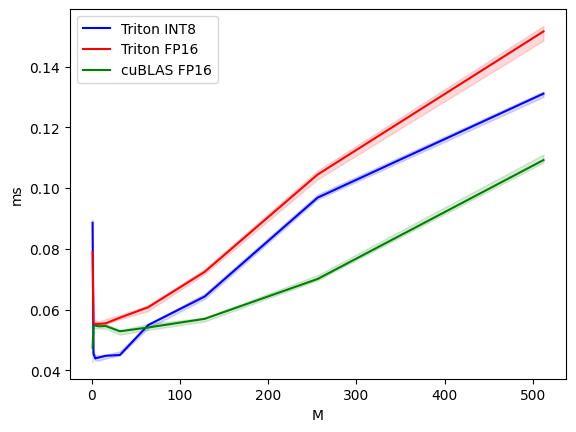

GeMV-performance-FP16 vs INT8:
       M  Triton INT8  Triton FP16  cuBLAS FP16
0    1.0     0.088576     0.078912     0.047424
1    2.0     0.045536     0.055456     0.054496
2    4.0     0.043936     0.055328     0.054752
3    8.0     0.044224     0.055296     0.054496
4   16.0     0.044800     0.055488     0.054592
5   32.0     0.045056     0.057344     0.052864
6   64.0     0.054912     0.060768     0.054112
7  128.0     0.064288     0.072416     0.056960
8  256.0     0.096848     0.104448     0.070080
9  512.0     0.131072     0.151552     0.109216


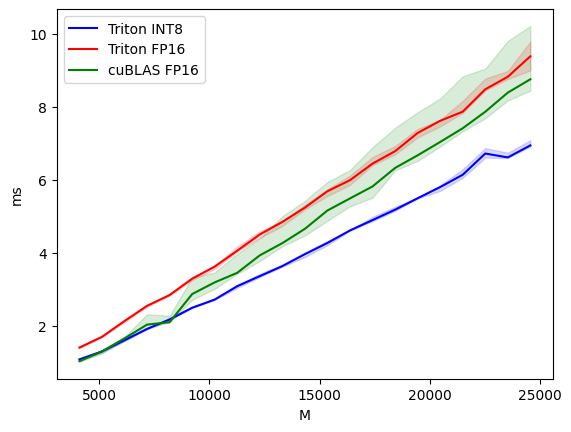

GeMM-performance-FP16 vs INT8:
          M  Triton INT8  Triton FP16  cuBLAS FP16
0    4096.0     1.077232     1.400832     1.028224
1    5120.0     1.296688     1.695840     1.293088
2    6144.0     1.602560     2.129376     1.654032
3    7168.0     1.912608     2.546016     2.031648
4    8192.0     2.171712     2.841440     2.096976
5    9216.0     2.492736     3.291136     2.868512
6   10240.0     2.717696     3.622624     3.188768
7   11264.0     3.085568     4.057456     3.451712
8   12288.0     3.360704     4.502768     3.930144
9   13312.0     3.635200     4.847552     4.264896
10  14336.0     3.963008     5.238416     4.657120
11  15360.0     4.269920     5.688896     5.159776
12  16384.0     4.612688     5.990336     5.490768
13  17408.0     4.896768     6.445216     5.819232
14  18432.0     5.181216     6.785312     6.326272
15  19456.0     5.495360     7.284736     6.672096
16  20480.0     5.801952     7.618560     7.038976
17  21504.0     6.139536     7.869152     7.414368


In [28]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(10)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["triton int8", "triton fp16", "cublas fp16"],  # Label name for the lines
        line_names=["Triton INT8", "Triton FP16", "cuBLAS FP16"],  # Line styles
        styles=[("blue", "-"), ("red", "-"), ("green", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMV-performance-" + ("FP16 vs INT8"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(4, 25)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["triton int8", "triton fp16", "cublas fp16"],  # Label name for the lines
        line_names=["Triton INT8", "Triton FP16", "cuBLAS FP16"],  # Line styles
        styles=[("blue", "-"), ("red", "-"), ("green", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="GeMM-performance-" + ("FP16 vs INT8"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark_quant_gemm).run(show_plots=True, print_data=True)

### On average, for GeMM, the implementation of TRITON INT8 is faster than cuBLAS FP16.

In [29]:
provider_funcs = {
    "torch": lambda a, b: quantize_int8(a),
    "triton": lambda a, b: quantize_int8_perrow(a)
}

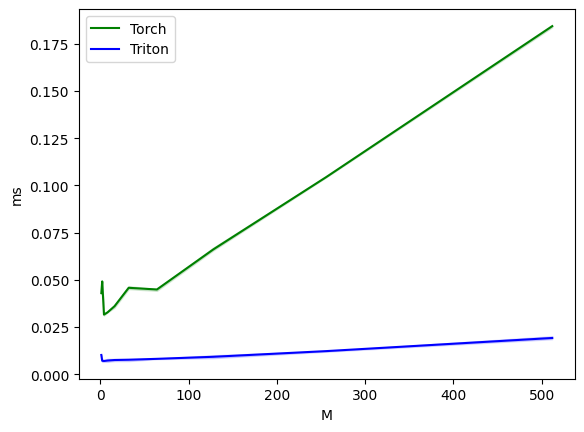

Quantize-performance-decoding:
       M     Torch    Triton
0    1.0  0.042976  0.010240
1    2.0  0.049184  0.007168
2    4.0  0.031616  0.007056
3    8.0  0.032768  0.007280
4   16.0  0.036064  0.007568
5   32.0  0.045792  0.007712
6   64.0  0.044912  0.008192
7  128.0  0.066144  0.009280
8  256.0  0.104448  0.012288
9  512.0  0.184320  0.019232


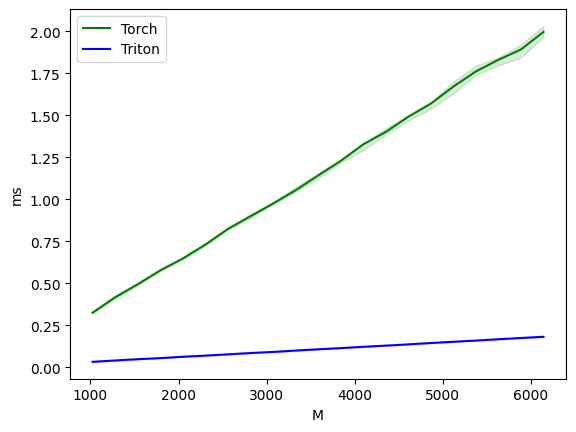

Quantize-performance-prefill:
         M     Torch    Triton
0   1024.0  0.325632  0.033312
1   1280.0  0.417824  0.041360
2   1536.0  0.494912  0.049056
3   1792.0  0.577600  0.055360
4   2048.0  0.648048  0.063488
5   2304.0  0.731056  0.070208
6   2560.0  0.824080  0.077824
7   2816.0  0.899552  0.085696
8   3072.0  0.974944  0.092240
9   3328.0  1.053728  0.100352
10  3584.0  1.142160  0.108032
11  3840.0  1.228560  0.114816
12  4096.0  1.327552  0.122880
13  4352.0  1.400832  0.129712
14  4608.0  1.491680  0.137216
15  4864.0  1.569888  0.145408
16  5120.0  1.671408  0.152704
17  5376.0  1.761472  0.159872
18  5632.0  1.830880  0.167872
19  5888.0  1.892352  0.175168
20  6144.0  1.996800  0.182336


In [30]:
configs = [
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[2 ** i for i in range(10)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["torch", "triton"],  # Label name for the lines
        line_names=["Torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="Quantize-performance-" + ("decoding"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
    triton.testing.Benchmark(
        x_names=["M"],  # Argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(4, 25)],  # Different possible values for `x_name`
        line_arg="provider",  # Argument name whose value corresponds to a different line in the plot
        # Possible values for `line_arg`
        line_vals=["torch", "triton"],  # Label name for the lines
        line_names=["Torch", "Triton"],  # Line styles
        styles=[("green", "-"), ("blue", "-")],
        ylabel="ms",  # Label name for the y-axis
        plot_name="Quantize-performance-" + ("prefill"),  # Name for the plot, used also as a file name for saving the plot.
        args={"provider_funcs": provider_funcs},
    ),
]


triton.testing.perf_report(configs)(benchmark).run(show_plots=True, print_data=True)

### Triton quantization is an order of magnitude faster than Torch.